# This explores the random forest classifier, with grid search and smote

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np
import joblib




In [ ]:
df = pd.read_csv('preprocessed.csv')

In [25]:
print("Number of rows in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])

Number of rows in the dataset: 7032
Number of columns in the dataset: 27


In [26]:
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   Unnamed: 0  Senior Citizen  Partner  Dependents  Tenure  Phone Service  \
0           0           False     True       False       1          False   
1           1           False    False       False      34           True   
2           2           False    False       False       2           True   
3           3           False    False       False      45          False   
4           4           False    False       False       2           True   

   Multiple Lines  Online Security  Online Backup  Device Protection  ...  \
0           False            False           True              False  ...   
1           False             True          False               True  ...   
2           False             True           True              False  ...   
3           False             True          False               True  ...   
4           False            False          False              False  ...   

   Internet Service_DSL  Internet Service_Fi

In [27]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                7032 non-null   int64  
 1   Senior Citizen                            7032 non-null   bool   
 2   Partner                                   7032 non-null   bool   
 3   Dependents                                7032 non-null   bool   
 4   Tenure                                    7032 non-null   int64  
 5   Phone Service                             7032 non-null   bool   
 6   Multiple Lines                            7032 non-null   bool   
 7   Online Security                           7032 non-null   bool   
 8   Online Backup                             7032 non-null   bool   
 9   Device Protection                         7032 non-null   bool   
 10  Tech Support         

In [28]:
df = df.astype({col:'int' for col in df.select_dtypes('bool').columns})
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Senior Citizen                            7032 non-null   int64  
 1   Partner                                   7032 non-null   int64  
 2   Dependents                                7032 non-null   int64  
 3   Tenure                                    7032 non-null   int64  
 4   Phone Service                             7032 non-null   int64  
 5   Multiple Lines                            7032 non-null   int64  
 6   Online Security                           7032 non-null   int64  
 7   Online Backup                             7032 non-null   int64  
 8   Device Protection                         7032 non-null   int64  
 9   Tech Support                              7032 non-null   int64  
 10  Streaming TV                        

In [32]:
# Features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (5625, 25)
Test size: (1407, 25)


In [ ]:

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

# Predict and evaluate
y_pred_best = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Accuracy: 0.749822316986496

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.82      1033
           1       0.52      0.73      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.75      0.76      1407



In [53]:
print("Best Hyperparameters Found by GridSearchCV:")
print(grid_search.best_params_)


Best Hyperparameters Found by GridSearchCV:
{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


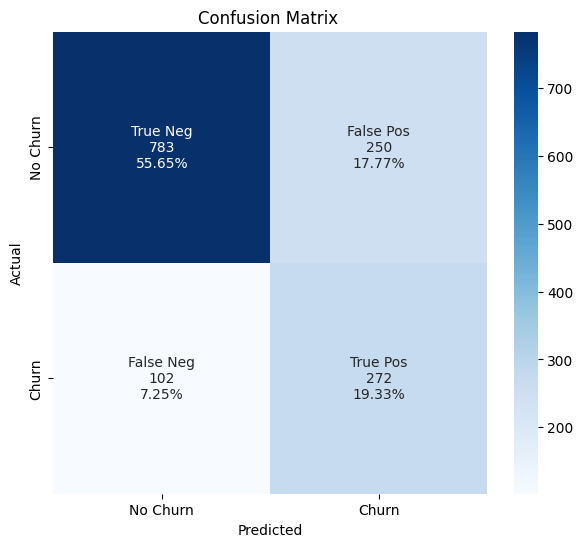

In [57]:

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

labels = ['No Churn', 'Churn']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
box_labels = [f"{name}\n{count}\n{percent}" for name, count, percent in zip(group_names, group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2,2)

# Plot
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix, annot=box_labels, fmt="", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


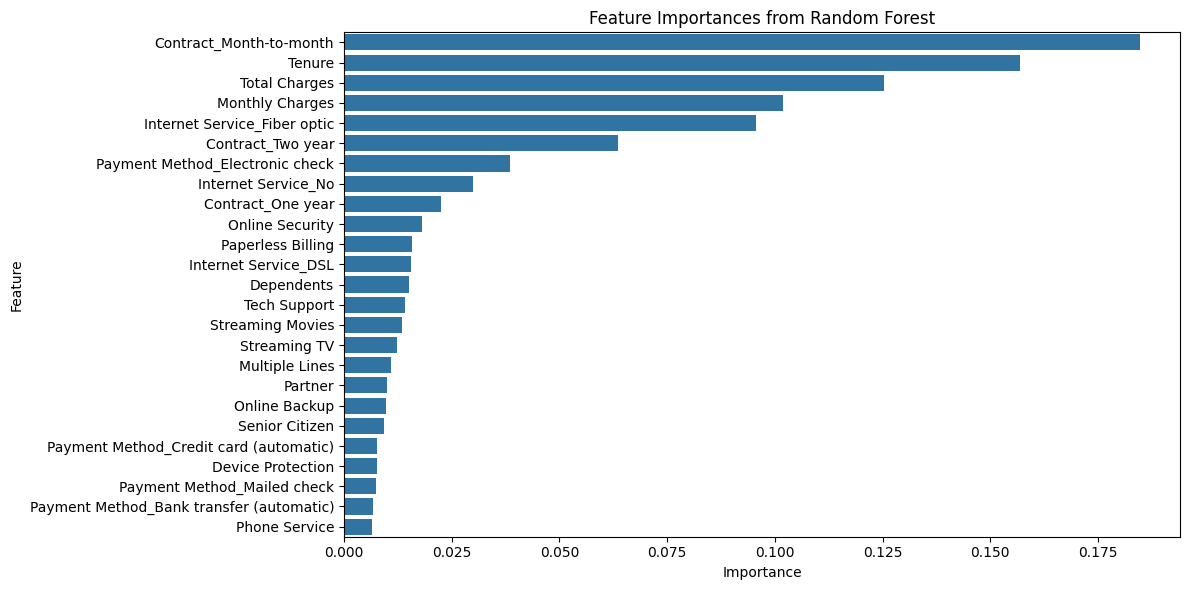

In [49]:
# Get importances
importances = best_rf.feature_importances_
features = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [52]:
joblib.dump(best_rf, 'random_forest_churn_model.pkl')


['random_forest_churn_model.pkl']

#SMOTE

In [54]:
from imblearn.over_sampling import SMOTE

# Create SMOTE instance
smote = SMOTE(random_state=42)

# Apply SMOTE to training data only
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:")
print(y_train_smote.value_counts())


Resampled class distribution:
Churn
1    4130
0    4130
Name: count, dtype: int64


c:\Users\Stayner\anaconda3\envs\AI-Project_Churn\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Stayner\anaconda3\envs\AI-Project_Churn\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Stayner\anaconda3\envs\AI-Project_Churn\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Stayner\anaconda3\envs\AI-Project_Churn\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Stayner\anaconda3\envs\AI-Project_Churn\lib\subprocess.py", line 1456, in _exe

In [55]:
rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)

# Train on the balanced data
rf_smote.fit(X_train_smote, y_train_smote)

# Predict on the original test set
y_pred_smote = rf_smote.predict(X_test)


Accuracy: 0.7626154939587776

 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1033
           1       0.54      0.66      0.60       374

    accuracy                           0.76      1407
   macro avg       0.71      0.73      0.71      1407
weighted avg       0.78      0.76      0.77      1407



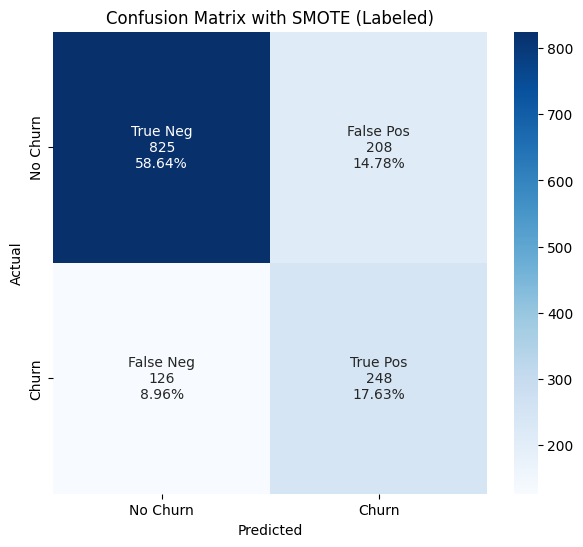

In [60]:
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\n Classification Report:\n", classification_report(y_test, y_pred_smote))


# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_smote)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in conf_matrix.flatten()]
group_percentages = [f"{value:.2%}" for value in conf_matrix.flatten() / np.sum(conf_matrix)]
box_labels = [f"{name}\n{count}\n{percent}" for name, count, percent in zip(group_names, group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2,2)

plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=box_labels, fmt='', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix with SMOTE (Labeled)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
joblib.dump(rf_smote, 'webapp/assets/models/rfc_smote_gs.pkl')

['random_forest_churn_model_smote.pkl']